<a href="https://colab.research.google.com/github/Lucasl3/grafos/blob/main/Atividade3/Atividade03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atividade 03 - Grafo de visibilidade de robô

In [ ]:
import numpy as np
from shapely.geometry import LineString, Point, Polygon
import queue
from matplotlib import pyplot as plt

Considere o problema de planejamento de caminho para veículos autônomos. Existem formas diferentes de representar o mapa em que o algoritmo de planejamento deve atuar. Em uma atividade anterior, nos preocupamos com mapas definidos por células, agora vamos trabalhar com uma representação topológica do ambiente (a versão mais à esquerda na figura abaixo).

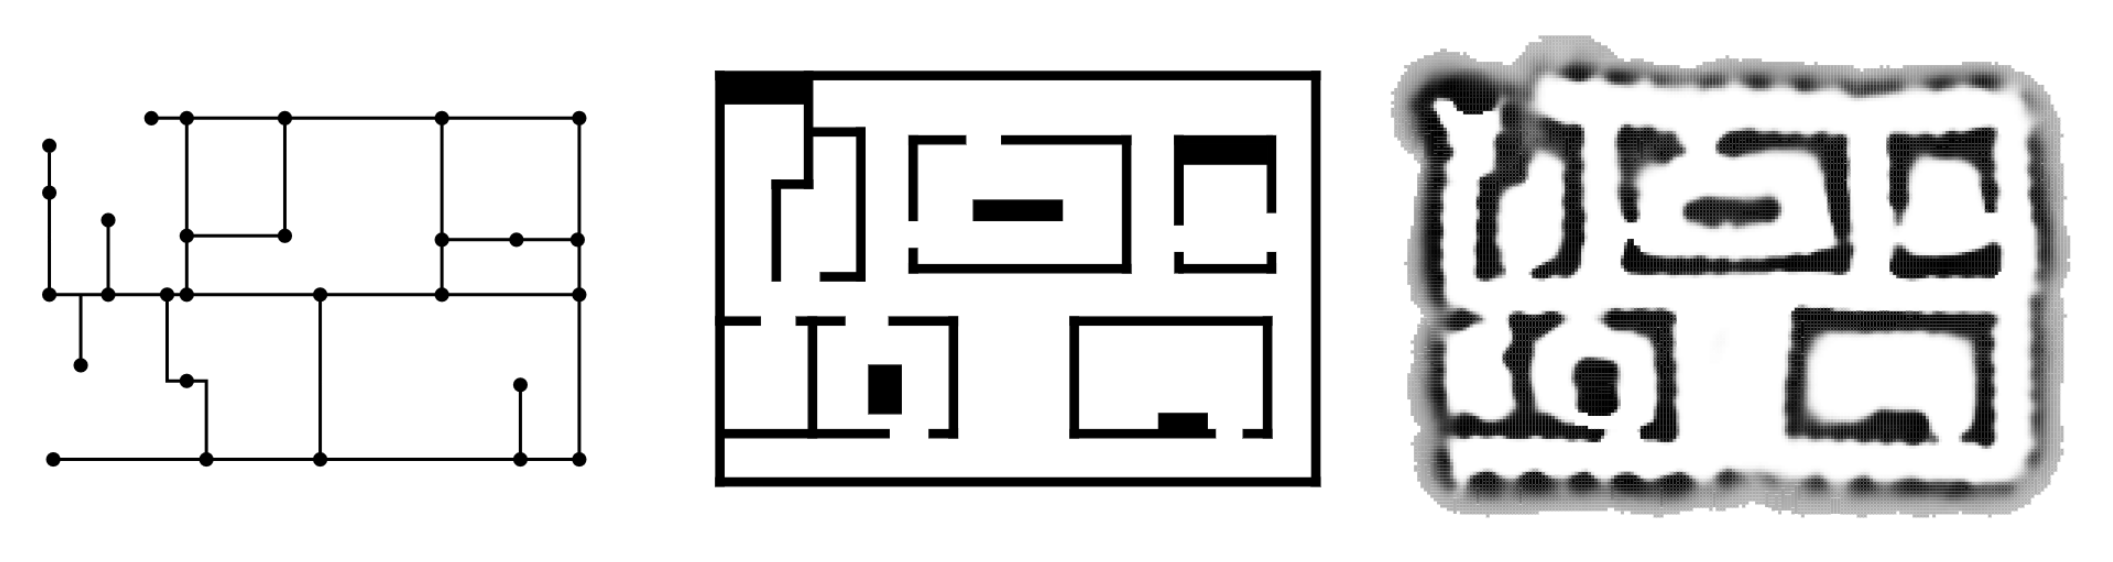

Podemos montar esse tipo de mapa, em um espaço poligonal, com uma técnica conhecida como Grafo de Visibilidade. A técnica pode ser observada no início do capítulo *Roadmaps* do livro [*Principles of Robot Motion*](https://mitpress.mit.edu/books/principles-robot-motion). Em resumo, consideramos como vértices regiões de interesse, como a posição inicial e desejada do robô, além dos pontos de "quinas" dos obstáculos.

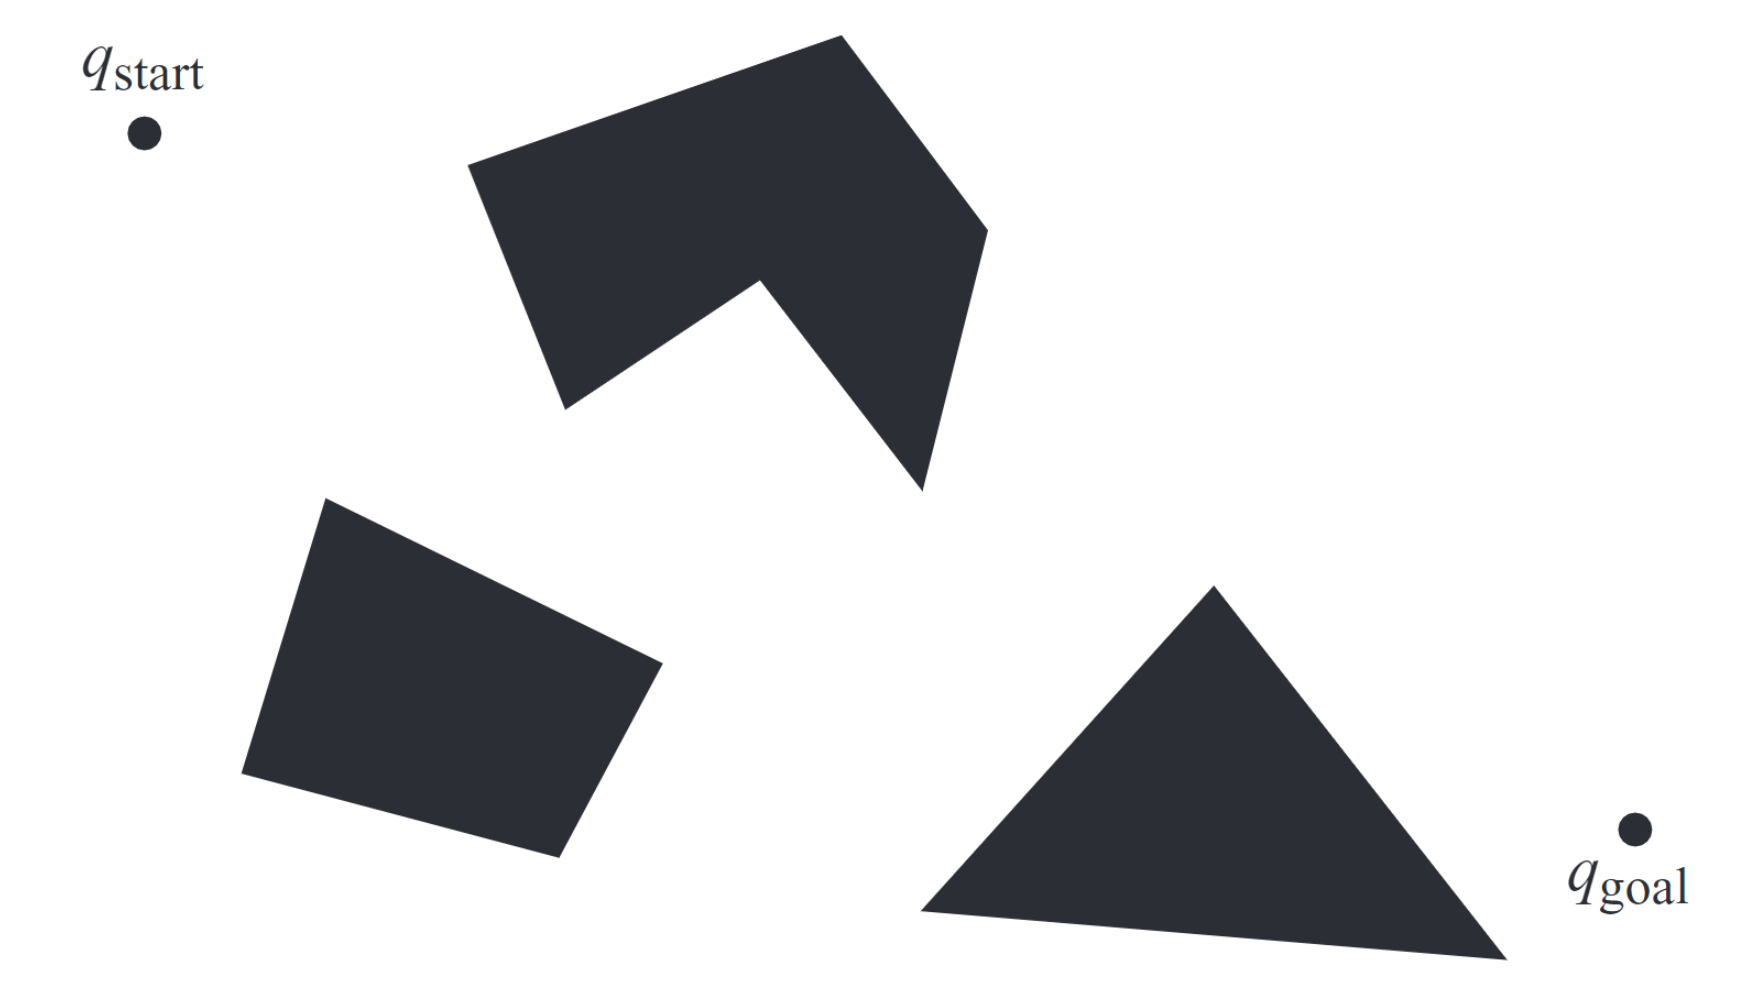

In [ ]:
# Considere que o arquivo esteja no formato a seguir:
# q_start_x, q_start_y
# q_goal_x, q_goal_y
# <numero de obstaculos>
# <numero de quinas>
# x_quina, y_quina
# ...

def getInformationsFromFile(arquivo):
  file_graph = open(arquivo, 'r')

  start_point = tuple(map(float, file_graph.readline().rstrip().split(',')))
  goal_point = tuple(map(float, file_graph.readline().rstrip().split(',')))

  number_obstacles = int(file_graph.readline())

  # vertices = [start_point]
  vertices = []
  obstacles_vertices = []
  
  for i in range(number_obstacles):
    number_points = int(file_graph.readline())
    current_vertices = []
    for j in range(number_points):
      vertex = tuple(map(float, file_graph.readline().rstrip().split(',')))
      vertices.append(vertex)
      current_vertices.append(vertex)

    obstacles_vertices.append(current_vertices)
  # vertices.append(goal_point)

  return vertices, obstacles_vertices, start_point, goal_point

Dizemos que existe aresta entre dos vértices se houver visada direta entre eles, ou seja, se montamos uma linha reta entre os dois pontos, não há obstáculo, o robô se mantém no espaço de configurações livres de colisão. Podemos formalizar essa característica com a seguinte combinação convexa:

$$e_{ij} \neq \emptyset ⇔ sv_i + (1 - s)v_j \in \text{cl}(\mathcal{Q}_{free})$$

Será preciso resolver um problema de *Point-In-Polygon* para saber se algum ponto no decorrer da combinação convexa está no interior de um dos obstáculos. Fica como dica a biblioteca shapely, mas se sintam livres para usar outras abordagens. Considere como custo da aresta a distância entre os vértices.

Gerando um grafo como o a seguir:
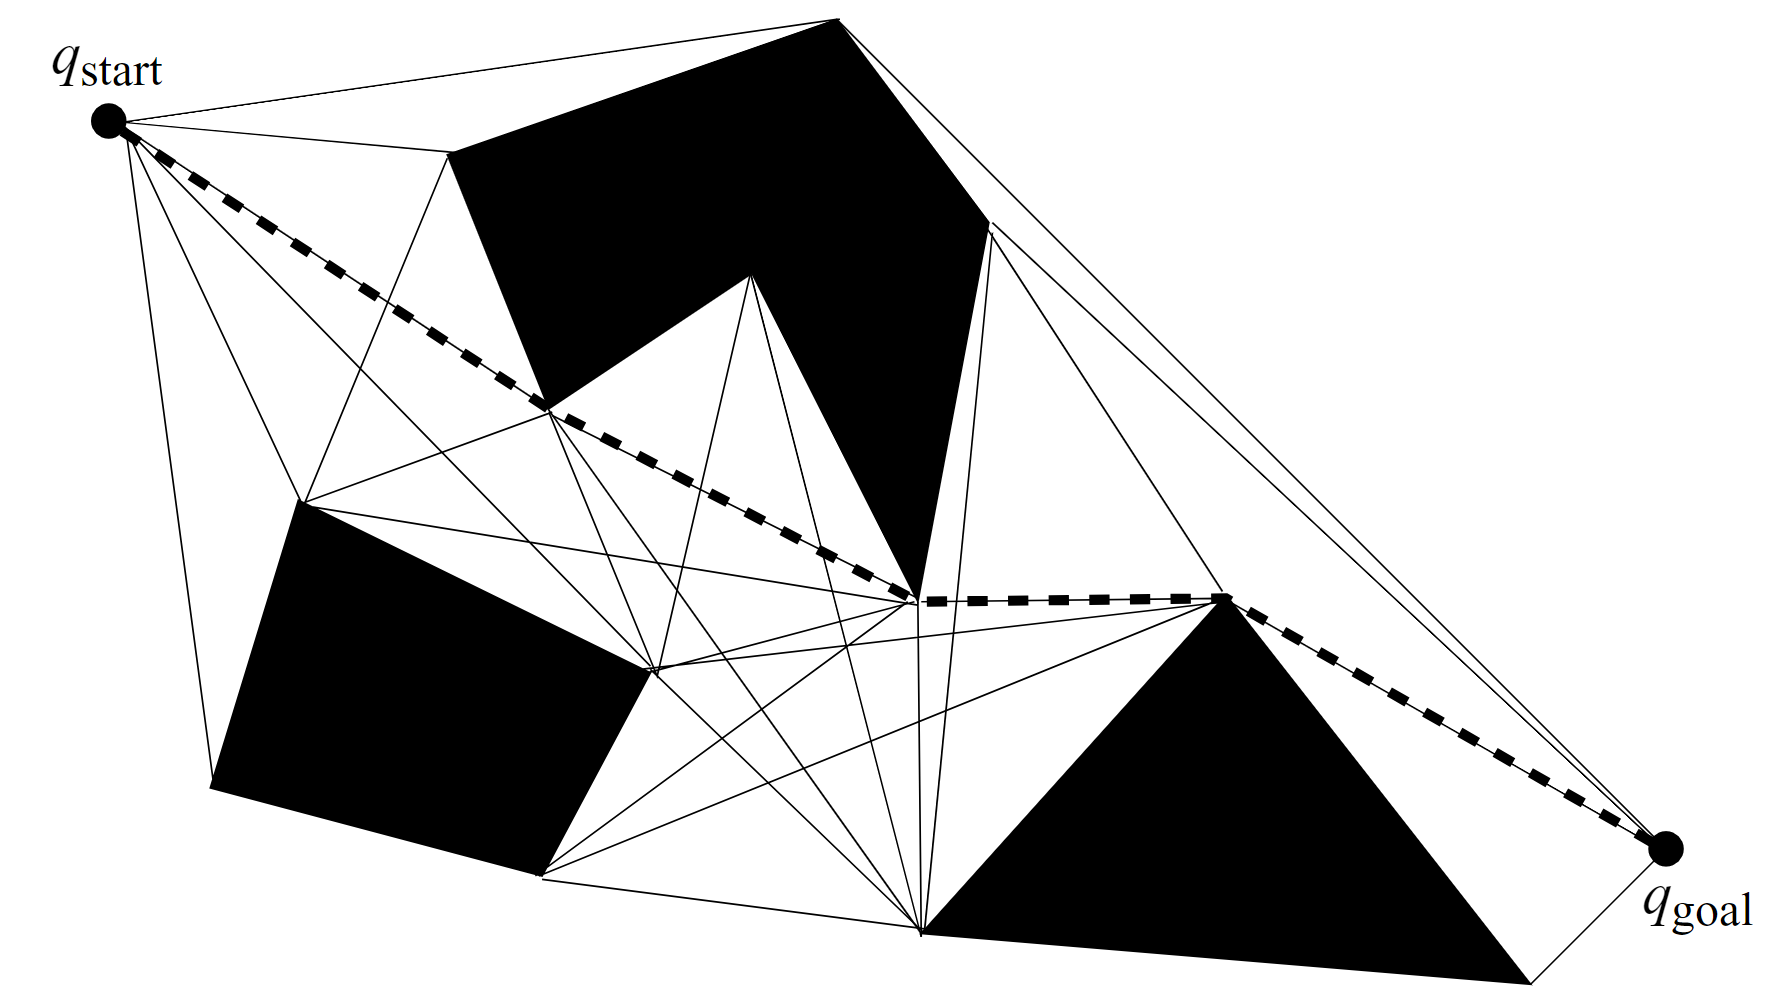

In [ ]:
vertices, obstacles_vertices, start_point, goal_point = getInformationsFromFile("mapa.txt")
print(vertices)
obstacles_vertices

[(2.0, 3.5), (1.5, 1.5), (3.5, 0.9), (4.5, 2.0), (5.5, 10.5), (2.5, 9.75), (2.75, 5.5), (5.0, 7.0), (6.25, 5.25), (6.5, 8.0), (8.5, 3.25), (7.5, 0.5), (9.25, 0.25)]


[[(2.0, 3.5), (1.5, 1.5), (3.5, 0.9), (4.5, 2.0)],
 [(5.5, 10.5), (2.5, 9.75), (2.75, 5.5), (5.0, 7.0), (6.25, 5.25), (6.5, 8.0)],
 [(8.5, 3.25), (7.5, 0.5), (9.25, 0.25)]]

In [ ]:
def getSegments(obstacles_vertices):
  segments = []
  for obstacles in obstacles_vertices:
    for i in range(len(obstacles)) :
      if i != len(obstacles) - 1:
        segments.append((obstacles[i], obstacles[i+1]))
      else: 
        segments.append((obstacles[i], obstacles[0]))
    
  return segments
      
obstacles_segments = getSegments(obstacles_vertices)
obstacles_segments

[((2.0, 3.5), (1.5, 1.5)),
 ((1.5, 1.5), (3.5, 0.9)),
 ((3.5, 0.9), (4.5, 2.0)),
 ((4.5, 2.0), (2.0, 3.5)),
 ((5.5, 10.5), (2.5, 9.75)),
 ((2.5, 9.75), (2.75, 5.5)),
 ((2.75, 5.5), (5.0, 7.0)),
 ((5.0, 7.0), (6.25, 5.25)),
 ((6.25, 5.25), (6.5, 8.0)),
 ((6.5, 8.0), (5.5, 10.5)),
 ((8.5, 3.25), (7.5, 0.5)),
 ((7.5, 0.5), (9.25, 0.25)),
 ((9.25, 0.25), (8.5, 3.25))]

In [ ]:
def validSegments(from_vertex, to_vertex, segments):
  segments_copy = segments.copy()
  for segment in segments_copy:
    if (from_vertex in segment) or (to_vertex in segment):
      segments_copy.remove(segment)

  return segments_copy

def isInsideObstacle(path_attempt):
  point1, point2 = path_attempt
  x1, y1 = point1
  x2, y2 = point2
  
  x3 = (x1 + x2) / 2
  y3 = (y1 + y2) / 2

  point = Point(x3, y3)
  
  for obstacle in obstacles_vertices:
    poly = Polygon(obstacle)
    if point.within(poly):
      return True

  return False

def validNeighbor(path_attempt, segments):
  for obstacle in segments:
    if (path_attempt == obstacle) or (path_attempt == obstacle[::-1]):
      return False
    elif not ((path_attempt[0] in obstacle) or (path_attempt[1] in obstacle)):
      line = LineString(path_attempt)
      other = LineString(obstacle)

      if line.intersects(other):
        return False
    elif isInsideObstacle(path_attempt):
      return False
  
  return True


def createVisibilityGraph(V, segments, start_point='', goal_point=''):
  vertices = V.copy()

  if start_point and goal_point:
    vertices.insert(0, start_point)
    vertices.append(goal_point)

  visibility_graph = {}

  for vertex in vertices:
    others_vertices = vertices.copy()
    others_vertices.remove(vertex)
    
    for other_vertex in others_vertices:
      if validNeighbor((vertex, other_vertex), segments):
        # print(f"{vertex} to {other_vertex} is a valid path")
        if vertex in visibility_graph: visibility_graph[vertex].append(other_vertex)
        else: visibility_graph[vertex] = [other_vertex]
      else:
        # print(f"{vertex} to {other_vertex} is not a valid path")
        pass

  return visibility_graph
    

visibility_graph = createVisibilityGraph(vertices, obstacles_segments, start_point, goal_point)
visibility_graph

{(1.0, 10.0): [(2.0, 3.5), (1.5, 1.5), (5.5, 10.5), (2.5, 9.75), (2.75, 5.5)],
 (1.5, 1.5): [(1.0, 10.0), (2.5, 9.75)],
 (2.0, 3.5): [(1.0, 10.0),
  (2.5, 9.75),
  (2.75, 5.5),
  (5.0, 7.0),
  (6.25, 5.25),
  (8.5, 3.25),
  (7.5, 0.5)],
 (2.5, 9.75): [(1.0, 10.0), (2.0, 3.5), (1.5, 1.5)],
 (2.75, 5.5): [(1.0, 10.0),
  (2.0, 3.5),
  (4.5, 2.0),
  (6.25, 5.25),
  (8.5, 3.25),
  (7.5, 0.5)],
 (3.5, 0.9): [(8.5, 3.25), (7.5, 0.5), (9.25, 0.25)],
 (4.5, 2.0): [(2.75, 5.5), (5.0, 7.0), (6.25, 5.25), (8.5, 3.25), (7.5, 0.5)],
 (5.0, 7.0): [(2.0, 3.5), (4.5, 2.0), (7.5, 0.5)],
 (5.5, 10.5): [(1.0, 10.0), (8.5, 3.25), (10.0, 1.0)],
 (6.25, 5.25): [(2.0, 3.5), (4.5, 2.0), (2.75, 5.5), (8.5, 3.25), (7.5, 0.5)],
 (6.5, 8.0): [(8.5, 3.25), (7.5, 0.5), (10.0, 1.0)],
 (7.5, 0.5): [(2.0, 3.5),
  (3.5, 0.9),
  (4.5, 2.0),
  (2.75, 5.5),
  (5.0, 7.0),
  (6.25, 5.25),
  (6.5, 8.0)],
 (8.5, 3.25): [(2.0, 3.5),
  (3.5, 0.9),
  (4.5, 2.0),
  (5.5, 10.5),
  (2.75, 5.5),
  (6.25, 5.25),
  (6.5, 8.0),
  (10.0,

O grafo resultante serve como *roadmap*, não só para ir de $q_{\text{start}}$ para $q_{\text{goal}}$, mas permite planejar caminhos do veículo para outras regiões do mapa. Tudo isso usando técnicas de teoria dos grafos.
Sabendo que o veículo sempre inicia em uma certa posição, podemos explorar algoritmos de busca ainda mais eficientes na estrutura de árvore. Pretende-se então descobrir qual a árvore que passa por todos os vértices e o custo total é mínimo. Esse problema pode ser trabalhado com os algoritmos de Kruskal e Prim, implemente ambos algoritmos.

In [ ]:
def plotMST(nodes, title):
  plt.figure(figsize=(16, 9))
  plt.title(title, fontsize=20)
  for node in nodes:
    from_node, to_node, distance = node
    x1, x2 = from_node[0], to_node[0]
    y1, y2 = from_node[1], to_node[1]

    x3, y3 = (x1 + x2) / 2, (y1 + y2) / 2

    plt.plot(from_node[0], from_node[1], "bo", markersize=10)
    plt.text(from_node[0] + 0.1, from_node[1] + 0.1, f'({from_node[0]}, {from_node[1]})')

    plt.plot(to_node[0], to_node[1], "bo", markersize=10)
    plt.text(to_node[0] + 0.1, to_node[1] + 0.1, f'({to_node[0]}, {to_node[1]})')

    plt.plot([x1, x2], [y1, y2], 'bo', linestyle="-")
    plt.text(x3, y3 + 0.07, f'{round(distance, 2)}')

In [ ]:
def find(parent, i):
  if parent[i] == i:
      return i
  return find(parent, parent[i])

def apply_union(parent, rank, x, y):
  xroot, yroot = find(parent, x), find(parent, y)
  if rank[xroot] < rank[yroot]:
      parent[xroot] = yroot
  elif rank[xroot] > rank[yroot]:
      parent[yroot] = xroot
  else:
      parent[yroot] = xroot
      rank[xroot] += 1

def getEdgeWeight(U, V):
  line_to = LineString([U, V])
  return line_to.length

def getWeightedVertices(G):
  pqueue = queue.PriorityQueue()
  
  for node in G.keys():
    for child in G[node]:
      weight = getEdgeWeight(node, child)
      pqueue.put((weight, node, child))
  
  return pqueue

def mstKruskal(G):
  mst = []
  parent, rank = {}, {}
  i, e = 0, 0

  pqueue = getWeightedVertices(G)
  V = len(G)

  for node in G.keys():
    parent[node] = node
    rank[node] = 0

  while e < V - 1:
    w, u, v = pqueue.get()

    x, y = find(parent, u), find(parent, v)
    if x != y:
      e = e + 1
      mst.append((u, v, w))
      apply_union(parent, rank, x, y)

  return mst
  
  
  

minimum_spanning_tree_kruskal = mstKruskal(visibility_graph)
minimum_spanning_tree_kruskal

[((9.25, 0.25), (10.0, 1.0), 1.0606601717798212),
 ((1.0, 10.0), (2.5, 9.75), 1.5206906325745548),
 ((2.0, 3.5), (2.75, 5.5), 2.1360009363293826),
 ((8.5, 3.25), (10.0, 1.0), 2.704163456597992),
 ((6.25, 5.25), (8.5, 3.25), 3.010398644698074),
 ((4.5, 2.0), (7.5, 0.5), 3.3541019662496847),
 ((2.75, 5.5), (6.25, 5.25), 3.5089172119045497),
 ((4.5, 2.0), (6.25, 5.25), 3.69120576505835),
 ((3.5, 0.9), (7.5, 0.5), 4.019950248448356),
 ((1.0, 10.0), (5.5, 10.5), 4.527692569068709),
 ((2.0, 3.5), (5.0, 7.0), 4.6097722286464435),
 ((1.0, 10.0), (2.75, 5.5), 4.828301978956992),
 ((6.5, 8.0), (8.5, 3.25), 5.153882032022076),
 ((1.5, 1.5), (2.5, 9.75), 8.31038506929733)]

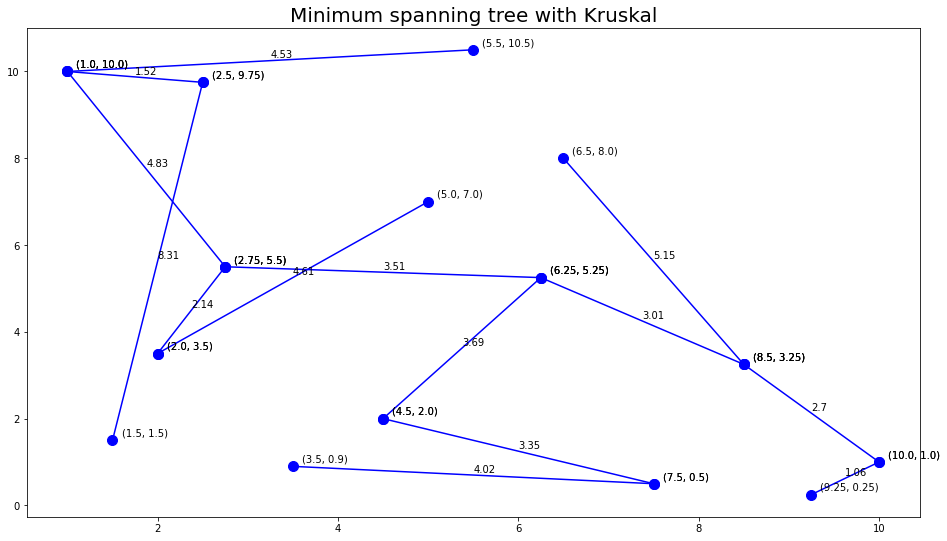

In [ ]:
plotMST(minimum_spanning_tree_kruskal, "Minimum spanning tree with Kruskal")

In [ ]:
def getEdgeWeight(U, V):
  line_to = LineString([U, V])
  return line_to.length

def mstPrim(G):
  V = len(G)
  visited = {}
  e = 0
  mst, nodes = [], []

  for node in G.keys():
    visited[node] = False
    start_node = node

  visited[start_node] = True
  nodes.append(start_node)

  while e < V - 1:
    nearest_neighbor = {
      "father": '',
      "coords": '',
      "distance": np.inf,
    }
    
    for node in nodes:
      for neighbor in G[node]:
        distance = getEdgeWeight(node, neighbor)
        if (distance < nearest_neighbor["distance"]) and not visited[neighbor]:
          nearest_neighbor["father"] = node
          nearest_neighbor["coords"] = neighbor
          nearest_neighbor["distance"] = distance

    mst.append((nearest_neighbor['father'], nearest_neighbor['coords'], nearest_neighbor["distance"]))
    nodes.append(nearest_neighbor["coords"])
    visited[nearest_neighbor["coords"]] = True

    e += 1
  
  return mst
  


minimum_spanning_tree_prims = mstPrim(visibility_graph)
minimum_spanning_tree_prims

[((10.0, 1.0), (9.25, 0.25), 1.0606601717798212),
 ((10.0, 1.0), (8.5, 3.25), 2.704163456597992),
 ((8.5, 3.25), (6.25, 5.25), 3.010398644698074),
 ((6.25, 5.25), (2.75, 5.5), 3.5089172119045497),
 ((2.75, 5.5), (2.0, 3.5), 2.1360009363293826),
 ((6.25, 5.25), (4.5, 2.0), 3.69120576505835),
 ((4.5, 2.0), (7.5, 0.5), 3.3541019662496847),
 ((7.5, 0.5), (3.5, 0.9), 4.019950248448356),
 ((2.0, 3.5), (5.0, 7.0), 4.6097722286464435),
 ((2.75, 5.5), (1.0, 10.0), 4.828301978956992),
 ((1.0, 10.0), (2.5, 9.75), 1.5206906325745548),
 ((1.0, 10.0), (5.5, 10.5), 4.527692569068709),
 ((8.5, 3.25), (6.5, 8.0), 5.153882032022076),
 ((2.5, 9.75), (1.5, 1.5), 8.31038506929733)]

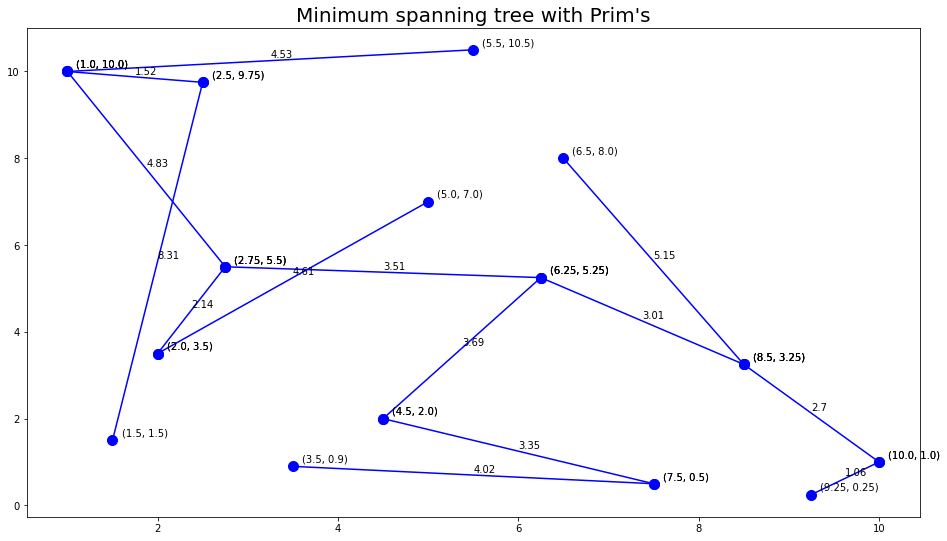

In [ ]:
plotMST(minimum_spanning_tree_prims, "Minimum spanning tree with Prim's")

Caso o robô inicie em um local não contemplado com um vértice, podemos fazer um caminho até o vértice mais próximo e de lá seguir o *roadmap* para o local desejado. Portanto, precisamos de uma rotina que descubra qual o vértice do grafo mais próximo dado um ponto no plano.

In [ ]:
def nearestVertex(T, position):
  nearest_vertex = {
      "coords": (0, 0),
      "distance_to": np.inf
  }
  
  if position in T.keys(): return position

  for coords in T.keys():
    line_to = LineString([position, coords])
    distance_to = line_to.length

    if distance_to < nearest_vertex["distance_to"]:
      nearest_vertex = {
          "coords": coords,
          "distance_to": distance_to
      }

  print(f"Nearest vertex from {position} is {nearest_vertex['coords']}, distance to is {nearest_vertex['distance_to']}")

  return nearest_vertex["coords"]

position = (4.7, 4.3)
nearestVertex(visibility_graph, position)

Nearest vertex from (4.7, 4.3) is (6.25, 5.25), distance to is 1.8179658962697842


(6.25, 5.25)

Agora é possível encontrar o caminho de  $q_{\text{start}}$ para $q_{\text{goal}}$. Para isso, pode ser usada uma técnica padrõa de busca de árvore, seja busca por lagura, profundidade ou mesmo A*.

In [ ]:
def plotObstacles(obstacles_vertices):
  for obstacle in obstacles_vertices:
    V = len(obstacle)
    for i in range(V):
      from_node = obstacle[i%V]
      to_node = obstacle[(i+1)%V]
      x1, x2 = from_node[0], to_node[0]
      y1, y2 = from_node[1], to_node[1]
      
      plt.plot(from_node[0], from_node[1], "bo", markersize=5)
      plt.text(from_node[0] + 0.1, from_node[1] + 0.1, f'({from_node[0]}, {from_node[1]})')

      plt.plot(to_node[0], to_node[1], "bo", markersize=5)
      plt.text(to_node[0] + 0.1, to_node[1] + 0.1, f'({to_node[0]}, {to_node[1]})')

      plt.plot([x1, x2], [y1, y2], 'bo', linestyle="-")

def plotMinimumPath(path, obstacles_vertices):
  plt.figure(figsize=(16, 9))
  plt.title("Minimum path with Dijkstra", fontsize=20)

  plotObstacles(obstacles_vertices)

  n = len(path)
  for i in range(n-1):
    from_node = path[i]
    to_node = path[i+1]
    x1, x2 = from_node[0], to_node[0]
    y1, y2 = from_node[1], to_node[1]

    plt.plot(from_node[0], from_node[1], "ro", markersize=10)
    if i == 0: plt.text(from_node[0] - 0.4, from_node[1] - 0.1, 'start', fontsize=12)

    plt.plot(to_node[0], to_node[1], "ro", markersize=10)
    if i == n-2: plt.text(to_node[0] - 0.4, to_node[1] - 0.1, 'goal', fontsize=12)
    plt.plot([x1, x2], [y1, y2], 'ro', linestyle="-")


In [ ]:
import queue

def unvisitedNeighbors(U, matriz_distance, graph):
  return [neighbor for neighbor in graph[U] if matriz_distance[neighbor]["unvisited"]]

def getEdgeWeight(U, V):
  line_to = LineString([U, V])
  return line_to.length

def getPath(start, end, matriz_distance):
  path = []
  current_node = end
  distance = matriz_distance[current_node]["distance"]
  while current_node != start:
    path.append(current_node)
    current_node = matriz_distance[current_node]["previous"]
  path.append(start)
  path.reverse()

  return (path, distance)

def dijkstraAlgorithm(graph, start):
  matriz_distance = {}
  priority_queue = queue.PriorityQueue()

  for V in graph:
    matriz_distance[V] = {
        "unvisited": True,
        "distance": np.inf,
        "previous": None
    }
    if V == start:
      matriz_distance[V]["distance"] = 0
      priority_queue.put((0, V))

  while not priority_queue.empty():
    distance, U = priority_queue.get()
    unvisited_neighbors = unvisitedNeighbors(U, matriz_distance, graph)
    for neighbor in unvisited_neighbors:
      temp_distance = distance + getEdgeWeight(U, neighbor)
      if temp_distance < matriz_distance[neighbor]["distance"]:
        matriz_distance[neighbor]["distance"] = temp_distance
        matriz_distance[neighbor]["previous"] = U
        priority_queue.put((temp_distance, neighbor))
    
    matriz_distance[U]["unvisited"] = False

  return matriz_distance

In [ ]:
def findPath(visibility_graph, pos_inicial, pos_final):
  v_inicial = nearestVertex(visibility_graph, pos_inicial)
  v_final = nearestVertex(visibility_graph, pos_final)

  matriz_distance = dijkstraAlgorithm(visibility_graph, v_inicial)

  return getPath(v_inicial, v_final, matriz_distance)

pos_inicial = (1, 10)
pos_final = (10, 1)

visibility_graph = createVisibilityGraph(vertices, obstacles_segments, pos_inicial, pos_final)

path, distance = findPath(visibility_graph, pos_inicial, pos_final)
print(path)
print(distance)

[(1, 10), (2.75, 5.5), (8.5, 3.25), (10, 1)]
13.70700995316922


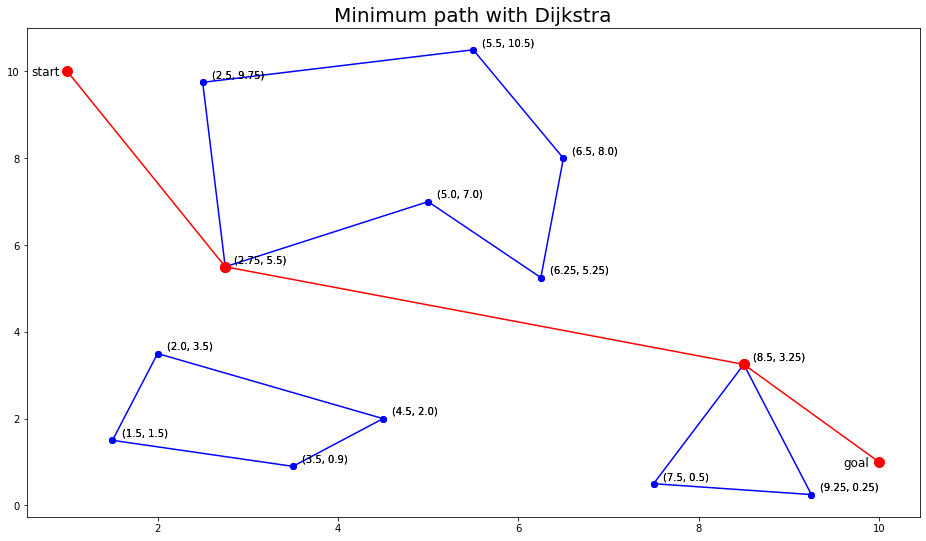

In [ ]:
plotMinimumPath(path, obstacles_vertices)

Da mesma forma, para um par de pontos aleatórios do mapa.

In [ ]:
pos_inicial = (1.2, 2.4)
pos_final = (10, 0.2)

visibility_graph = createVisibilityGraph(vertices, obstacles_segments)

path, distance = findPath(visibility_graph, pos_inicial, pos_final)
print(path)
print(distance)

Nearest vertex from (1.2, 2.4) is (1.5, 1.5), distance to is 0.9486832980505138
Nearest vertex from (10, 0.2) is (9.25, 0.25), distance to is 0.7516648189186453
[(1.5, 1.5), (2.5, 9.75), (2.0, 3.5), (7.5, 0.5), (3.5, 0.9), (9.25, 0.25)]
30.65190796648047


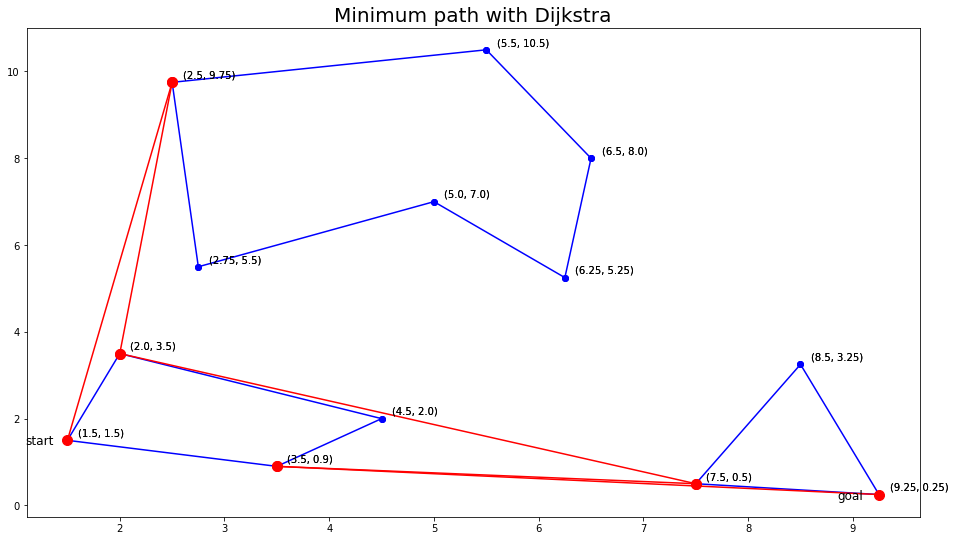

In [ ]:
plotMinimumPath(path, obstacles_vertices)